<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

To Download any pandas dataframe to exel, follow this code:
Here `world_industry_values` is python variable of pd.DataFrame type

```python
world_industry_values.to_excel('filename.xlsx')
```

In [ ]:
%%time

## Installation of external files
!wget -q https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

## Installation of external python libraries
!pip install -q pyxlsb

CPU times: user 724 ms, sys: 119 ms, total: 843 ms
Wall time: 1min 50s


In [ ]:
%%time

import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
from pyxlsb import open_workbook as open_xlsb
from glob import glob

CPU times: user 1.18 s, sys: 136 ms, total: 1.31 s
Wall time: 1.63 s


## SEA

In [ ]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 15.2 s, sys: 153 ms, total: 15.4 s
Wall time: 23.6 s


In [ ]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [ ]:
year_range = list(range(2000,2015))

## Convert to USD $

In [ ]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [ ]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [ ]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [ ]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [ ]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
12724,FIN,EMPE,C22,1.547830e+01,1.533749e+01,1.541292e+01,1.412858e+01,1.436912e+01,1.449700e+01,1.473765e+01,1.579458e+01,1.655510e+01,1.395718e+01,14.1,1.542023e+01,1.564144e+01,1.497821e+01,1.481978e+01
4856,CAN,GO_QI,K64,6.602050e+01,6.792546e+01,6.973450e+01,7.409666e+01,8.000527e+01,8.426448e+01,9.159061e+01,9.618164e+01,1.014554e+02,9.654076e+01,100.0,1.041736e+02,1.077838e+02,1.121847e+02,1.164835e+02
23174,KOR,VA,M72,4.856976e+06,5.693108e+06,6.798938e+06,7.993398e+06,9.350825e+06,1.037468e+07,1.189907e+07,1.422519e+07,1.693026e+07,1.832120e+07,20510395.0,2.264248e+07,2.477188e+07,2.680941e+07,2.879825e+07
31134,PRT,K,T,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Industry PPP in Adjusted USD $



In [ ]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
52,B,GO,5.555618e+07,6.408735e+07,5.247943e+07,5.811678e+07,9.069022e+07,1.956739e+08,2.734332e+08,3.904234e+08,6.160542e+08,7.034212e+08,1.004026e+09,1.583124e+09,1.776523e+09,1.902099e+09,1.878503e+09
68,C10-C12,GO,1.881692e+08,2.306442e+08,2.647098e+08,2.809759e+08,3.097317e+08,3.412415e+08,4.301856e+08,5.998739e+08,9.705961e+08,1.278884e+09,1.468689e+09,1.747287e+09,1.983977e+09,2.199417e+09,2.625205e+09
564,I,GO,1.093885e+08,1.219533e+08,1.664316e+08,1.735998e+08,1.804136e+08,2.018969e+08,2.518451e+08,3.054787e+08,3.713697e+08,4.442465e+08,5.469952e+08,6.339903e+08,7.200967e+08,8.520668e+08,9.894031e+08
420,F,GO,1.914346e+08,2.121205e+08,2.335117e+08,2.759392e+08,3.311831e+08,4.166025e+08,5.497744e+08,6.998217e+08,1.097048e+09,1.641040e+09,2.107729e+09,2.467873e+09,2.913631e+09,3.446983e+09,4.202676e+09
596,J59_J60,GO,2.220780e+07,2.382738e+07,2.918461e+07,3.174822e+07,3.674497e+07,4.183279e+07,4.977437e+07,5.813583e+07,7.085388e+07,8.219431e+07,9.510026e+07,1.091959e+08,1.217420e+08,1.340119e+08,1.463310e+08


## Industry Total in Current Dollars

In [ ]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
484,H49,GO,1.283619e+06,1.275094e+06,1.335785e+06,1.515459e+06,1.736292e+06,1.916254e+06,2.100036e+06,2.379499e+06,2.660739e+06,2.392736e+06,2.677105e+06,3.011597e+06,3.059951e+06,3.147885e+06,3.253021e+06
836,Q,GO,2.379523e+06,2.455128e+06,2.663925e+06,3.043294e+06,3.403364e+06,3.669782e+06,3.885912e+06,4.295915e+06,4.736786e+06,4.822789e+06,5.077950e+06,5.556253e+06,5.662411e+06,5.807470e+06,5.988951e+06
404,E37-E39,GO,2.214582e+05,2.250929e+05,2.442677e+05,2.811263e+05,3.218271e+05,3.441245e+05,3.690165e+05,4.100337e+05,4.455629e+05,4.006547e+05,4.344614e+05,4.860660e+05,4.716608e+05,4.804685e+05,4.942679e+05
788,N,GO,1.513877e+06,1.528481e+06,1.573150e+06,1.783519e+06,1.989855e+06,2.181219e+06,2.374693e+06,2.705715e+06,2.949002e+06,2.627109e+06,2.800468e+06,3.094821e+06,3.124793e+06,3.265580e+06,3.401792e+06
180,C21,GO,4.188048e+05,4.398083e+05,4.841489e+05,5.543763e+05,6.086000e+05,6.576197e+05,7.078356e+05,7.970437e+05,8.834686e+05,8.623580e+05,9.247430e+05,1.032971e+06,1.051887e+06,1.092137e+06,1.105962e+06


## PPP Ratio

In [ ]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
855,R_S,H_EMPE,0.804800,0.728819,0.705704,0.708652,0.715376,0.702829,0.681539,0.692261,0.671634,0.602671,0.577555,0.570921,0.502010,0.455760,0.420714
15,A01,VA_QI,0.795282,0.704170,0.750428,0.817330,0.868341,0.864088,0.840871,0.861865,0.870144,0.890731,0.795345,0.781328,0.696666,0.692824,0.709694
438,G45,GO_QI,0.876645,0.791469,0.804635,0.899333,0.950782,0.905511,0.891214,0.947969,0.940988,0.852756,0.795345,0.799635,0.722755,0.717799,0.704324
484,H49,GO,0.019824,0.016363,0.015012,0.013808,0.013579,0.010753,0.007883,0.008490,0.007494,0.007186,0.006905,0.007112,0.006587,0.005630,0.004722
671,K65,VA_QI,0.841460,0.799902,0.784306,0.847568,0.859601,0.808876,0.817549,0.857706,0.892345,0.820024,0.795345,0.809486,0.730082,0.732355,0.714784


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [ ]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [ ]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [ ]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [ ]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

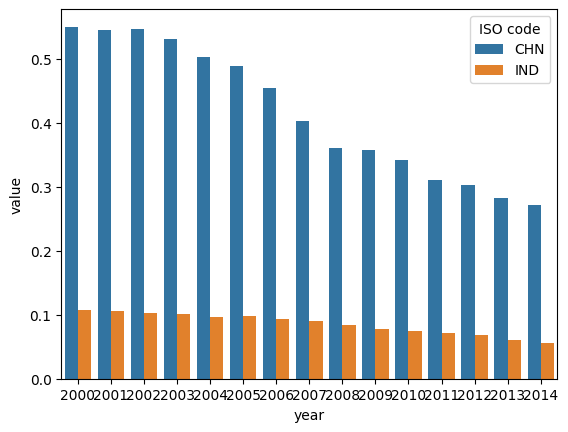

In [ ]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [ ]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31
3,AUS,CAP,B,2000,28250.15
4,AUS,CAP,C10-C12,2000,6401.86


In [ ]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:01<00:00, 531.76 country/s]


CPU times: user 2.2 s, sys: 109 ms, total: 2.3 s
Wall time: 2.41 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,9739.77,10285.682219
1,1,AUS,CAP,A02,2000,582.69,615.349661
2,2,AUS,CAP,A03,2000,869.31,918.034657
3,3,AUS,CAP,B,2000,28250.15,29833.565426
4,4,AUS,CAP,C10-C12,2000,6401.86,6760.683011


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

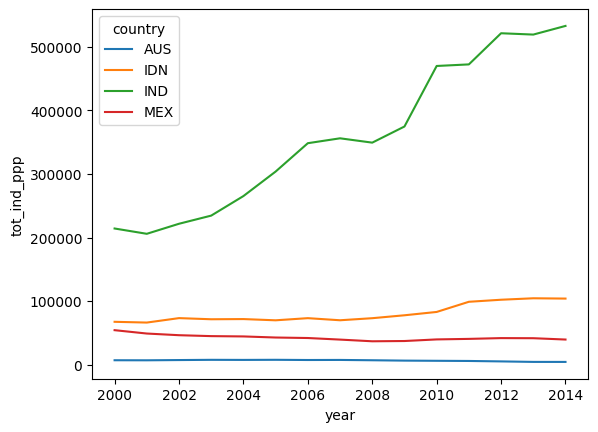

In [ ]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [ ]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,3.508316e+06
1,A01,2001,3.605992e+06
2,A01,2002,3.598810e+06
3,A01,2003,3.736123e+06
4,A01,2004,4.060107e+06


In [ ]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,0.364607
1,A01,2001,0.354486
2,A01,2002,0.359874
3,A01,2003,0.394123
4,A01,2004,0.420667


In [ ]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [ ]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:00<00:00, 734.14 country/s]


CPU times: user 1.04 s, sys: 15.3 ms, total: 1.05 s
Wall time: 1.07 s


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,0.364607,AUS,0.385043
1,A02,2000,0.389933,AUS,0.411789
2,A03,2000,0.353583,AUS,0.373401
3,B,2000,0.432509,AUS,0.456751
4,C10-C12,2000,0.516493,AUS,0.545442


### Country Industry PPP

In [ ]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1).copy()
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
7492,BRA,M69_M70,2003,49630.635,0.639445,31736.056490
10008,CHE,K64,2004,53377.042,0.520209,27767.233691
35765,RUS,J59_J60,2014,0.000,0.047088,0.000000
27112,DNK,C18,2011,9593.000,0.113019,1084.187966
11614,ROU,C33,2004,1684.100,0.807068,1359.182720


### World Industry Value

In [ ]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
822,T,2012,20183.635177,4.432151e+06
285,C29,2000,15598.938700,1.360459e+08
488,H51,2008,3096.529000,7.280140e+07


In [ ]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 265.88 country/s]

CPU times: user 172 ms, sys: 1.06 ms, total: 173 ms
Wall time: 177 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08


### Calculate homogeneous Labour

In [ ]:
world_industry_values['hom_labour'] = world_industry_values['country_ind_ppp']*world_industry_values['H_EMPE']/world_industry_values['GO']
world_industry_values.head()

,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08,17.710345
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07,0.925310
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07,0.341182
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08,1.545888
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08,3.066506


In [ ]:
# world_industry_values.to_excel('world_industry_values.xlsx')

### Plotting Homogeneous Labour in $

<Axes: xlabel='year', ylabel='hom_labour'>

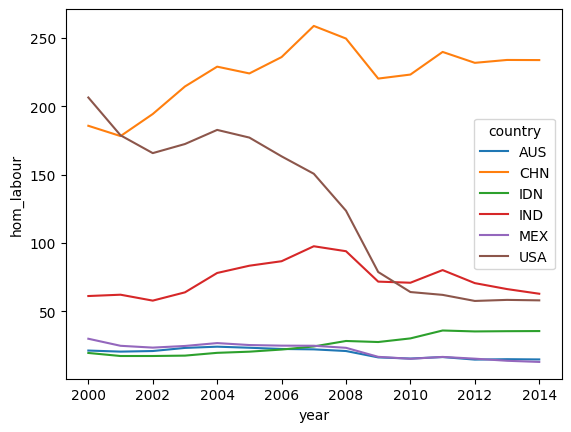

In [ ]:
countries = ['IND','AUS', 'IDN', "MEX", "CHN", "USA"]
data_filter = world_industry_values.loc[(world_industry_values['country'].isin(countries)) & (world_industry_values['code']=='F')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

In [ ]:
world_industry_values.describe()

,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
count,3.612000e+04,36120.000000,3.612000e+04,36120.000000,3.612000e+04,36120.000000
mean,5.619546e+06,0.685653,3.922423e+04,30689.717916,2.416405e+08,7.269695
std,5.325138e+07,0.527020,1.351723e+05,46082.054314,3.378267e+08,31.752405
min,0.000000e+00,0.000131,0.000000e+00,0.047000,5.333060e+02,0.000000
25%,1.330175e+03,0.110109,1.040668e+03,5377.553750,4.553640e+07,0.117451
50%,1.417800e+04,0.707232,5.738215e+03,13112.225500,1.357937e+08,0.716327
75%,9.733963e+04,1.057976,2.497810e+04,27806.747975,3.130893e+08,3.601492
max,3.027433e+09,3.629009,3.550996e+06,262589.921600,3.359589e+09,1218.587163


## International Market Value (MV)


In [ ]:
SEA_USD_melt = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA_USD_GO_sum = SEA_USD_melt[['variable', 'value','year']][SEA_USD_melt['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()
SEA_HEMPE_sum = SEA[['variable', 'value','year']][SEA['variable']=='H_EMPE'].groupby('year').sum().drop('variable', axis=1).reset_index()

MEV = SEA_HEMPE_sum.copy().drop(['value'],axis=1)
MEV['MEV'] = SEA_USD_GO_sum['value']/SEA_HEMPE_sum['value']
MEV

,year,MEV
0,2000,35.672182
1,2001,35.106767
2,2002,36.289156
3,2003,40.565310
4,2004,44.970490
5,2005,48.518267
6,2006,51.818365
7,2007,57.581716
8,2008,63.241141
9,2009,59.048367


In [ ]:
SEA_USD[SEA_USD['variable'].isin(['K','GO']) & SEA_USD['country'].isin(['AUS','IND','IDN']) & SEA_USD['code'].isin(['A01'])]

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
224,AUS,GO,A01,28947.959607,30957.684782,25292.346147,34889.990730,39645.927147,42012.510005,36429.086769,46225.675125,50077.341148,45742.080250,59637.655072,69566.630072,71514.739400,71459.259903,70292.034587
616,AUS,K,A01,39799.823577,36621.912053,39886.941034,51153.411795,62475.631242,69397.728989,74810.750515,89284.205980,95409.814050,89407.729743,105799.862882,121320.090125,125052.330802,117797.242582,112960.598377
18144,IDN,GO,A01,26971.930614,25978.475942,32278.221116,37957.120563,38814.652384,39611.879177,48107.168776,58850.741114,72528.226851,78402.845333,101622.948793,116266.943957,117716.880941,117162.620089,112492.713475
18536,IDN,K,A01,16485.304380,15055.093134,17338.851907,20624.442909,22571.328982,24128.696928,30555.346030,35150.640028,41541.671734,49670.246555,64298.781250,73679.169033,75924.637625,73993.512164,73186.723423
19040,IND,GO,A01,119836.589230,124203.712177,118370.122574,139227.773247,148234.818901,171203.461777,187717.798071,234165.135845,252618.261511,259166.931408,330669.957272,366814.957198,356133.418999,369830.454361,369345.847310
19432,IND,K,A01,144783.369345,150529.383671,155776.699764,177687.930507,204865.721118,225550.763288,241886.573458,294734.657913,319021.854878,316632.345067,373975.773299,418691.262178,432533.549308,466389.238891,474219.622470


In [ ]:
SEA_USD_GO = SEA_USD_melt[SEA_USD_melt['variable']=='GO'].reset_index(drop=True)

SEA_USD_K = SEA_USD_melt[SEA_USD_melt['variable']=='K'].reset_index(drop=True)
SEA_USD_K.head()

,country,variable,code,year,value
0,AUS,K,A01,2000,39799.823577
1,AUS,K,A02,2000,1507.755523
2,AUS,K,A03,2000,2689.243546
3,AUS,K,B,2000,84688.831742
4,AUS,K,C10-C12,2000,12159.831139


### Calculate market price

In [ ]:
WIV_x = world_industry_values[['country', 'code', 'year', 'hom_labour']].copy()
WIV_x

,country,code,year,hom_labour
0,AUS,A01,2000,17.710345
1,AUS,A02,2000,0.925310
2,AUS,A03,2000,0.341182
3,AUS,B,2000,1.545888
4,AUS,C10-C12,2000,3.066506
...,...,...,...,...
36115,USA,P85,2014,51.614154
36116,USA,Q,2014,560.397987
36117,USA,R_S,2014,85.154775
36118,USA,T,2014,90.079776


In [ ]:
MVs=[]
for year, dfx in tqdm(WIV_x.groupby('year'), unit=' Year'):
    dfx['MEVLH'] = MEV.loc[MEV['year']==year,'MEV'].iloc[0]*dfx['hom_labour']
    MVs.append(dfx)

MV_data = pd.concat(MVs)
MV_data['K'] = SEA_USD_K['value']
MV_data['GO'] = SEA_USD_GO['value']
MV_data['MP'] = MV_data['K']+MV_data['GO']
MV_data['MV'] = MV_data['MEVLH']+MV_data['K']
MV_data['diff'] = MV_data['MP']-MV_data['MV']
MV_data.head(5)

100%|██████████| 15/15 [00:00<00:00, 960.16 Year/s]


,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
0,AUS,A01,2000,17.710345,631.766632,39799.823577,28947.959607,68747.783184,40431.590210,28316.192974
1,AUS,A02,2000,0.925310,33.007809,1507.755523,1506.081860,3013.837383,1540.763332,1473.074051
2,AUS,A03,2000,0.341182,12.170706,2689.243546,1512.383426,4201.626972,2701.414252,1500.212720
3,AUS,B,2000,1.545888,55.145213,84688.831742,34012.527846,118701.359588,84743.976955,33957.382633
4,AUS,C10-C12,2000,3.066506,109.388950,12159.831139,34168.387512,46328.218651,12269.220089,34058.998562


<Axes: xlabel='year', ylabel='diff'>

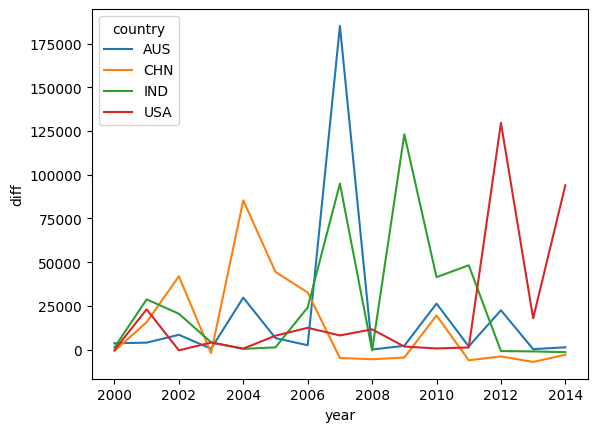

In [ ]:
countries = ['IND','USA','AUS','CHN']
data_filter = MV_data.loc[(MV_data['country'].isin(countries)) & (MV_data['code']=='C13-C15')].copy()
sns.lineplot(data=data_filter, x='year', y='diff', hue='country')

In [ ]:
MV_data['diff'].describe()

,diff
count,3.612000e+04
mean,3.883688e+04
std,1.320221e+05
min,-4.375939e+04
25%,7.823323e+02
50%,5.696780e+03
75%,2.600858e+04
max,3.403617e+06


## World Input Output Analysis

### Exports

In [ ]:
def extract_exports(df):
    columns = df.iloc[3,4:] +"_"+ df.iloc[4,4:]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_exp = df.iloc[5:-8, 4:].astype(float).copy().reset_index(drop=True)
    df_exp.columns=columns.values
    df_exp['supply'] = rows.values

    return df_exp

def filter_exports(df_exp):
    new_cols = []
    cols = [f"c{i}" for i in range(1,62)]
    for col in df_exp.columns[:-2]:
        country, ind = col.split("_")
        if ind in cols:
            new_cols.append(col)

    df_exp_filtered = df_exp[new_cols].copy()
    df_exp_filtered['supply'] = df_exp['supply']

    return df_exp_filtered

def calculate_exports(df_exp_filtered, df):

    exports = []

    for supply, dfx in df_exp_filtered.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        country,ind = supply.split("_")
        ind = ind.replace("_r","_c")
        sum_df = dfx.loc[:,(~dfx.columns.str.contains(country))]
        sum = sum_df.values.sum()

        exports.append([supply,sum])

    export_df = pd.DataFrame(exports, columns=['supply', 'exports'])


    output_GO_sum = df.iloc[5:-8,[2,3,-1]].copy()
    output_GO_sum.columns = ['country', 'code', 'GO']
    output_GO_sum['supply'] = output_GO_sum['country']+"_"+output_GO_sum['code']
    output_GO_sum.loc[output_GO_sum['GO']==0,'GO'] = float('nan')
    output_GO_sum = output_GO_sum[['supply', 'GO']].reset_index(drop=True)

    export_df_GO = pd.merge(
        left= export_df,
        right= output_GO_sum,
        on = 'supply',
        how='inner'
    )
    export_df_GO['export_total'] = export_df_GO['exports'] / export_df_GO['GO']

    return export_df_GO

### Imports

In [ ]:
def extract_imports(df):
    columns = df.iloc[3,4:-1] +"_"+ df.iloc[4,4:-1]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_Imp = df.iloc[5:-8, 4:-1].astype(float).copy().transpose().reset_index(drop=True)
    df_Imp.columns=rows.values
    df_Imp['supply'] = columns.values

    return df_Imp


def calculate_imports(df_Imp):
    Imports = []

    for supply, dfx in df_Imp.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        country,code = supply.split('_')
        new_supply = supply.replace("_c","_r")
        new_cols = [c for c in dfx.columns if c!=new_supply]

        sum_df = dfx.loc[:,new_cols]
        sum = sum_df.values.sum()

        ## Country filter
        col_country = [c for c in dfx.columns if country not in c]
        sum2 = dfx.loc[:,col_country].values.sum()

        Imports.append([supply,sum, sum2])

    import_df = pd.DataFrame(Imports, columns=['supply', 'imports_industry', 'imports_country'])
    return import_df

def get_total_imports(df,import_df):
    output_GO_sum = df.iloc[[3,4,-1],4:-1].transpose().copy()
    output_GO_sum.columns = ['country', 'code', 'GO']
    output_GO_sum['supply'] = output_GO_sum['country']+"_"+output_GO_sum['code']
    output_GO_sum.loc[output_GO_sum['GO']==0,'GO'] = float('nan')
    output_GO_sum = output_GO_sum[['supply', 'GO']].reset_index(drop=True)

    import_df_GO = pd.merge(
        left= import_df,
        right= output_GO_sum,
        on = 'supply',
        how='inner'
    )
    import_df_GO['import_tot_ind'] = import_df_GO['imports_industry'] / import_df_GO['GO']
    import_df_GO['import_tot_country'] = import_df_GO['imports_country'] / import_df_GO['GO']

    return import_df_GO

### Calculate exports and imports for years

In [ ]:
%%time

with ZipFile("wiot.zip", 'r') as zObject:
    zObject.extractall()

CPU times: user 6.58 s, sys: 1.44 s, total: 8.02 s
Wall time: 11.8 s


In [ ]:
IO_files = glob('WIOT*_Nov16_ROW.xlsb')
print(f"Total Input Output files: {len(IO_files)} found")

Total Input Output files: 15 found


In [ ]:
df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb', nrows=10)
df.head()

,Intercountry Input-Output Table,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2679,Unnamed: 2680,Unnamed: 2681,Unnamed: 2682,Unnamed: 2683,Unnamed: 2684,Unnamed: 2685,Unnamed: 2686,Unnamed: 2687,Unnamed: 2688
0,"43 countries, in current prices",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(industry-by-industry),NaN,NaN,NaN,A01,A02,A03,B,C10-C12,C13-C15,...,CONS_np,CONS_g,GFCF,INVEN,CONS_h,CONS_np,CONS_g,GFCF,INVEN,GO
2,(millions of US$),NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Total output
3,NaN,NaN,NaN,NaN,AUS,AUS,AUS,AUS,AUS,AUS,...,USA,USA,USA,USA,ROW,ROW,ROW,ROW,ROW,TOT
4,NaN,NaN,NaN,NaN,c1,c2,c3,c4,c5,c6,...,c58,c59,c60,c61,c57,c58,c59,c60,c61,c62


In [ ]:
df_industry = pd.DataFrame(list(zip(df.iloc[4, 4:4+56], df.iloc[1, 4:4+56])), columns = ['c_index', 'code'])
df_industry['r_index'] = df_industry['c_index'].str.replace("c",'r')
df_industry.head()

,c_index,code,r_index
0,c1,A01,r1
1,c2,A02,r2
2,c3,A03,r3
3,c4,B,r4
4,c5,C10-C12,r5


In [ ]:
# %%time

# import_dfs = []
# export_dfs = []


# for file in tqdm(IO_files):
#     year = pd.ExcelFile(file).sheet_names[0]
#     df = pd.read_excel(file, engine='pyxlsb')

#     ## Calculate exports:
#     df_exp = extract_exports(df)
#     df_exp_filtered = filter_exports(df_exp)
#     export_df = calculate_exports(df_exp_filtered,df)
#     export_df['year'] = year

#     ## Calculate imports:
#     df_Imp = extract_imports(df)
#     import_df = calculate_imports(df_Imp)
#     total_imports = get_total_imports(df,import_df)
#     total_imports['year'] = year

#     ## Add to list
#     export_dfs.append(export_df)
#     import_dfs.append(total_imports)

# imports_all = pd.concat(import_dfs)
# exports_all = pd.concat(export_dfs)

# exports_all.to_excel('exports.xlsx', index=False)
# imports_all.to_excel('imports.xlsx', index=False)

 33%|███▎      | 5/15 [07:21<14:36, 87.62s/it]

In [ ]:
%%time
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/exports.xlsx -O exports.xlsx
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/imports.xlsx -O imports.xlsx

exports_all = pd.read_excel('exports.xlsx').sort_values(by='year')
exports_all[['country', 'r_index']] = exports_all['supply'].str.split('_').to_list()
exports_all = exports_all.drop('supply', axis=1)

## Merge industry to the imports
exports_all = pd.merge(
    left=exports_all,
    right=df_industry,
    how='inner',
    on='r_index'
)

exports_all = exports_all.drop(['c_index', 'r_index'],axis=1)

imports_all = pd.read_excel('imports.xlsx').sort_values(by='year')
imports_all[['country', 'c_index']] = imports_all['supply'].str.split('_').to_list()
imports_all = imports_all.drop('supply', axis=1)

## Merge industry to the imports
imports_all = pd.merge(
    left=imports_all,
    right=df_industry,
    how='inner',
    on='c_index'
)

imports_all = imports_all.drop(['c_index', 'r_index'],axis=1)

CPU times: user 8.77 s, sys: 38.5 ms, total: 8.81 s
Wall time: 11.9 s


In [ ]:
exp_imp_df = pd.merge(
    left=imports_all,
    right=exports_all,
    on = ['code', 'country', 'year'],
    how='inner'
)

exp_imp_df.head(5)

,imports,import_total,year,country,code,exports,exports_total
0,10255.922610,6.809673,2000,AUS,C19,394.651441,0.262039
1,14196.684169,3.465066,2000,MEX,C19,242.637347,0.156499
2,216.719766,0.058925,2000,MLT,C19,0.953047,0.000000
3,26.354319,0.078433,2000,LVA,C19,2.620855,0.010868
4,3186.156550,0.613577,2000,NOR,C19,419.711727,0.570677


### Merge with DIFF

- MV['diff'] * exports_total on same industry, country and year
-

In [ ]:
MV_data.sample(5)

,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
31463,SVK,M73,2006,0.340299,17.633722,3476.701508,7570.70124,11047.402748,3494.335230,7553.067518
11863,FIN,M73,2001,0.373102,13.098402,910.144620,5958.18993,6868.334550,923.243022,5945.091528
29647,ROU,D35,2004,0.994813,44.737243,5037.443840,1789.85488,6827.298720,5082.181083,1745.117637
13814,GBR,J61,2006,4.141615,214.611731,30278.408160,23627.94720,53906.355360,30493.019891,23413.335469
27458,NOR,C28,2010,0.467550,30.069319,602.623248,1404.66720,2007.290448,632.692567,1374.597881


In [ ]:
imports_diff = pd.merge(
    left = exp_imp_df,
    right = MV_data,
    on = ['country', 'code', 'year'],
    how='inner'
)
exp_imp_df['unequal_exchange'] = (exp_imp_df['exports_total'] - exp_imp_df['import_total'])*imports_diff['diff']
exp_imp_df.sample(5)

,imports,import_total,year,country,code,exports,exports_total,unequal_exchange
5516,961.856646,0.166427,2005,BEL,C33,99.685938,0.007222,-0.000000
24572,8156.457164,7.685288,2003,CAN,J62_J63,941.336169,0.123856,-419647.043725
28318,12031.367718,0.154252,2013,CZE,L68,36.478885,0.006636,-378.675412
5986,32473.260900,1.287186,2001,FRA,G47,5801.720889,0.125833,-24766.760996
14556,8207.616538,18.080466,2000,GBR,C17,337.581136,0.055749,-24069.284886


<Axes: xlabel='year', ylabel='unequal_exchange'>

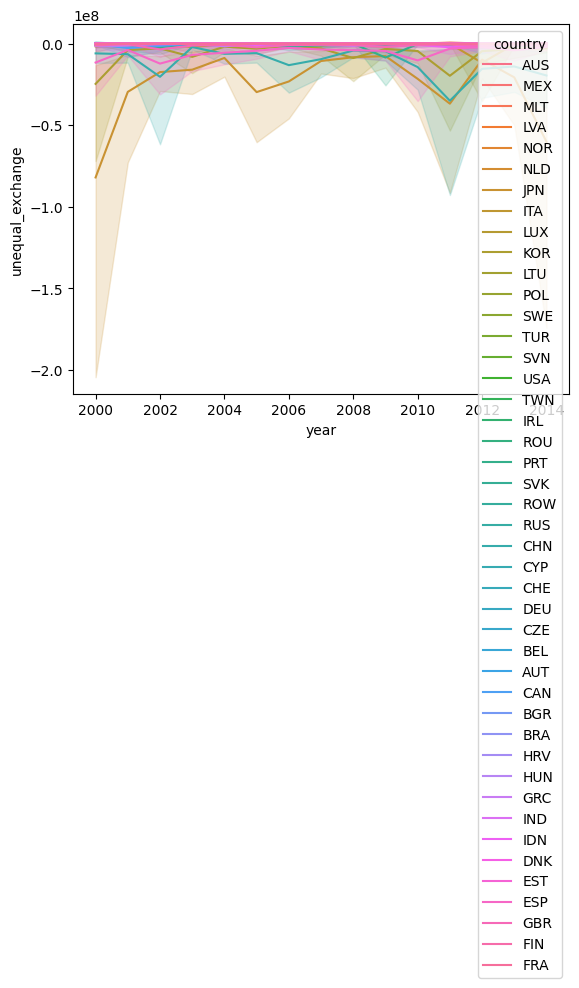

In [ ]:

sns.lineplot(x='year', y='unequal_exchange', data=exp_imp_df, hue='country')